Author: Nik Alleyne <br>
Author Blog: **https://www.securitynik.com** <br>
Author GitHub: **github.com/securitynik** <br>

Author Books: [  <br>

                "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/", 
                
                "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/" 
            ] 

### Why this series?
When teaching the SANS SEC595: Applied Data Science and Machine Learning for Cybersecurity Professionals 
**https://www.sans.org/cyber-security-courses/applied-data-science-machine-learning/** I am always asked,
"Will you be sharing your demo notebooks?" or "Can we get a copy of your demo notebooks?" or ... well you get the point.
My answer is always no. Not that I do not want to share, (sharing is caring :-D) , but the demo notebooks 
by themselves, would not make sense or add real value. Hence, this series! 

This is my supplemental work, similar to what I would do in the demos but with a lot more details and references.


## 24 - Continuing Unsupervised Learning - Zeek HTTP Log - Machine Learning

### The series includes the following: <br>
01 - Beginning Numpy <br>
02 - Beginning Tensorflow  <br>
03 - Beginning PyTorch <br>
04 - Beginning Pandas <br>
05 - Beginning Matplotlib <br>
06 - Beginning Data Scaling <br>
07 - Beginning Principal Component Analysis (PCA) <br>
08 - Beginning Machine Learning Anomaly Detection - Isolation Forest and Local Outlier Factor <br>
09 - Beginning Unsupervised Machine Learning - Clustering - K-means and DBSCAN <br>
10 - Beginning Supervise Learning - Machine Learning - Logistic Regression, Decision Trees and Metrics <br>
11 - Beginning Linear Regression - Machine Learning <br>
12 - Beginning Deep Learning - Anomaly Detection with AutoEncoders, Tensorflow <br>
13 - Beginning Deep Learning - Anomaly Detection with AutoEncoders, PyTroch <br>
14 - Beginning Deep Learning - Linear Regression, Tensorflow <br>
15 - Beginning Deep Learning - Linear Regression, PyTorch <br>
16 - Beginning Deep Learning - Classification, Tensorflow <br>
17 - Beginning Deep Learning - Classification, Pytorch <br>
18 - Beginning Deep Learning - Classification - regression - MIMO - Functional API Tensorflow <br> 
19 - Beginning Deep Learning - Convolution Networks - Tensorflow <br>
20 - Beginning Deep Learning - Convolution Networks - PyTorch <br>
21 - Beginning Regularization - Early Stopping, Dropout, L2 (Ridge), L1 (Lasso) <br>
22 - Beginning Model TFServing <br>

But conn.log is not the only log file within Zeek. Let's build some models for DNS and HTTP logs. <br>
I choose unsupervised, because there are no labels coming with these data. <br>

23 - Continuing Anomaly Learning - Zeek DNS Log - Machine Learning <br>
24 - Continuing Unsupervised Learning - Zeek HTTP Log - Machine Learning <br>

This was a specific ask by someone in one of my class. <br>
25 - Beginning - Reading Executables and Building a Neural Network to make predictions on suspicious vs suspicious  <br><br>

With 25 notebooks in this series, it is quite possible there are things I could have or should have done differently.  <br>
If you find any thing, you think fits those criteria, drop me a line. <br>

If you find this series beneficial, I would greatly appreciate your feedback.



Previously, we extracted data from the Zeek DNS log for a Zeek environment you might be using. <br>
Let's make this last post about using Zeek HTTP log  <br>

Get the data from the HTTP Log <br>
securitynik@lab:/opt/zeek/logs/current$ **zeek-cut id.orig_h id.resp_h id.resp_p trans_depth method host uri user_agent request_body_len response_body_len status_code info_code resp_mime_types < http.log > /tmp/zeek_http.log**


Get the file via SSH <br>
PS D:\OtherML\Beginning_ML> **scp securitynik@peeper:/tmp/zeek_http.log .**
securitynik@peeper's password: <br>
zeek_http.log                                                                 100%  503KB  10.4MB/s   00:00

In [1]:
# import some libraries
import pandas as pd
import numpy as np

In [2]:
# Read the HTTP log data
# We learned about Pandas in the notebook
#   04 - Beginning Pandas
df_http = pd.read_csv(filepath_or_buffer=r'./zeek_http.log', header=None, sep='\t', \
                     names=['id.orig_h', 'id.resp_h', 'id.resp_p', 'trans_depth', 'method', 'host', \
                        'uri', 'user_agent', 'request_body_len', 'response_body_len', \
                            'status_code', 'info_code', 'resp_mime_types'], na_values=['-','', '0']).reset_index(drop=True)

# The results return shows we have 5431 records with 8 columns
df_http

,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,request_body_len,response_body_len,status_code,info_code,resp_mime_types
0,10.0.0.10,172.16.1.83,1234,91,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,NaN,455.0,200.0,NaN,text/plain
1,10.0.0.10,172.16.1.83,1234,92,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,NaN,926464.0,200.0,NaN,video/mp2t
2,10.0.0.10,172.16.1.83,1234,93,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,NaN,455.0,200.0,NaN,text/plain
3,10.0.0.10,172.16.1.83,1234,94,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,NaN,908416.0,200.0,NaN,video/mp2t
4,10.0.0.10,104.26.5.178,80,67,GET,testing1.sn,/securitynik_up/server/load.php?type=watchdog&...,Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWeb...,NaN,164.0,200.0,NaN,text/json
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,10.0.0.10,172.16.3.74,1234,848,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,NaN,791104.0,200.0,NaN,video/mp2t
2857,10.0.0.10,172.16.3.74,1234,849,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/mono.m3u8?to...,Securitynik-agent,NaN,455.0,200.0,NaN,text/plain
2858,10.0.0.10,172.16.3.74,1234,850,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,NaN,1588224.0,200.0,NaN,video/mp2t
2859,10.0.0.10,172.16.3.74,1234,851,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,NaN,616640.0,200.0,NaN,video/mp2t


This file represents Zeek (formerly Bro) HTTP log - http.log`. 
Zeek is a framework used for Network Security Monitoring. 
This entire series is based on using Zeek's data. 
The majority of the notebooks use the conn.log
You can learn more about Zeek here:
   
    https://zeek.org/

Alternatively, come hang out with us in the:
SANS SEC595: Applied Data Science and Machine Learning for Cybersecurity Professionals

        https://www.sans.org/cyber-security-courses/applied-data-science-machine-learning/ OR

SEC503 SEC503: Network Monitoring and Threat Detection In-Depth

        https://www.sans.org/cyber-security-courses/network-monitoring-threat-detection/


Here are also some blog posts on using Zeek for security monitoring
Installing Zeek: 

        https://www.securitynik.com/2020/06/installing-zeek-314-on-ubuntu-2004.html

Detecting PowerShell Empire Usage: 

        https://www.securitynik.com/2022/02/powershell-empire-detection-with-zeek.html

Detecting Log4J Vulnerability Exploitation: 

        https://www.securitynik.com/2021/12/continuing-log4shell-zeek-detection.html


In [3]:
# Get information on the features
df_http.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2861 entries, 0 to 2860
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id.orig_h          2861 non-null   object 
 1   id.resp_h          2861 non-null   object 
 2   id.resp_p          2861 non-null   int64  
 3   trans_depth        2861 non-null   int64  
 4   method             2861 non-null   object 
 5   host               2861 non-null   object 
 6   uri                2861 non-null   object 
 7   user_agent         2861 non-null   object 
 8   request_body_len   0 non-null      float64
 9   response_body_len  1156 non-null   float64
 10  status_code        1163 non-null   float64
 11  info_code          0 non-null      float64
 12  resp_mime_types    1156 non-null   object 
dtypes: float64(4), int64(2), object(7)
memory usage: 290.7+ KB


In [4]:
# Do we have any rows that is reporting as null
# This is no surprise, we saw by just looking at the dataset above
#   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html
df_http.isnull().sum()

id.orig_h               0
id.resp_h               0
id.resp_p               0
trans_depth             0
method                  0
host                    0
uri                     0
user_agent              0
request_body_len     2861
response_body_len    1705
status_code          1698
info_code            2861
resp_mime_types      1705
dtype: int64

In [5]:
# A different view
#   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html
# Same here
df_http.isna().sum()

id.orig_h               0
id.resp_h               0
id.resp_p               0
trans_depth             0
method                  0
host                    0
uri                     0
user_agent              0
request_body_len     2861
response_body_len    1705
status_code          1698
info_code            2861
resp_mime_types      1705
dtype: int64

In [6]:
# Describing the data to identify what value to fill the missing fields with
df_http.describe()

,id.resp_p,trans_depth,request_body_len,response_body_len,status_code,info_code
count,2861.000000,2861.000000,0.0,1.156000e+03,1163.000000,0.0
mean,1163.816148,1749.224747,NaN,5.884965e+05,201.331040,NaN
std,275.849576,1244.091547,NaN,6.918148e+05,11.650813,NaN
min,80.000000,1.000000,NaN,1.000000e+02,200.000000,NaN
25%,1234.000000,401.000000,NaN,4.550000e+02,200.000000,NaN
50%,1234.000000,2140.000000,NaN,4.496960e+05,200.000000,NaN
75%,1234.000000,2855.000000,NaN,1.128752e+06,200.000000,NaN
max,1234.000000,3570.000000,NaN,3.104256e+06,308.000000,NaN


In [7]:
# Looks like we should immediately drop the request_body_len and info_code fields.
# doing that
df_http = df_http.drop(columns=['request_body_len', 'info_code'], inplace=False)
df_http

,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,response_body_len,status_code,resp_mime_types
0,10.0.0.10,172.16.1.83,1234,91,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,text/plain
1,10.0.0.10,172.16.1.83,1234,92,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,926464.0,200.0,video/mp2t
2,10.0.0.10,172.16.1.83,1234,93,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,text/plain
3,10.0.0.10,172.16.1.83,1234,94,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,908416.0,200.0,video/mp2t
4,10.0.0.10,104.26.5.178,80,67,GET,testing1.sn,/securitynik_up/server/load.php?type=watchdog&...,Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWeb...,164.0,200.0,text/json
...,...,...,...,...,...,...,...,...,...,...,...
2856,10.0.0.10,172.16.3.74,1234,848,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,791104.0,200.0,video/mp2t
2857,10.0.0.10,172.16.3.74,1234,849,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/mono.m3u8?to...,Securitynik-agent,455.0,200.0,text/plain
2858,10.0.0.10,172.16.3.74,1234,850,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,1588224.0,200.0,video/mp2t
2859,10.0.0.10,172.16.3.74,1234,851,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,616640.0,200.0,video/mp2t


In [8]:
# Do we have any other field with NaN values that we did not easily see?
# Yep! We will need to address those
df_http[df_http.isna().any(axis=1)]

,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,response_body_len,status_code,resp_mime_types
7,10.0.0.10,172.16.0.111,1234,2129,GET,fit.lab.co:9999,/23607d40258f4f1dd83839cbe3adf3/tracks-v1a1/20...,Securitynik-agent,NaN,NaN,NaN
8,10.0.0.10,172.16.0.111,1234,1928,GET,fit.lab.co:9999,/23607d40258f4f1dd83839cbe3adf3/tracks-v1a1/20...,Securitynik-agent,NaN,NaN,NaN
9,10.0.0.10,172.16.0.111,1234,2143,GET,fit.lab.co:9999,/23607d40258f4f1dd83839cbe3adf3/tracks-v1a1/mo...,Securitynik-agent,NaN,NaN,NaN
10,10.0.0.10,172.16.0.111,1234,1895,GET,fit.lab.co:9999,/23607d40258f4f1dd83839cbe3adf3/tracks-v1a1/mo...,Securitynik-agent,NaN,NaN,NaN
11,10.0.0.10,172.16.0.111,1234,2841,GET,fit.lab.co:9999,/23607d40258f4f1dd83839cbe3adf3/tracks-v1a1/mo...,Securitynik-agent,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2090,10.0.0.52,72.21.81.240,80,3,GET,ctldl.windowsupdate.com,/msdownload/update/v3/static/trustedr/en/pinru...,Microsoft-CryptoAPI/10.0,NaN,304.0,NaN
2091,10.0.0.52,72.21.81.240,80,1,GET,ctldl.windowsupdate.com,/msdownload/update/v3/static/trustedr/en/disal...,Microsoft-CryptoAPI/10.0,NaN,304.0,NaN
2092,10.0.0.52,72.21.81.240,80,2,GET,ctldl.windowsupdate.com,/msdownload/update/v3/static/trustedr/en/authr...,Microsoft-CryptoAPI/10.0,NaN,304.0,NaN
2093,10.0.0.52,72.21.81.240,80,3,GET,ctldl.windowsupdate.com,/msdownload/update/v3/static/trustedr/en/pinru...,Microsoft-CryptoAPI/10.0,NaN,304.0,NaN


In [9]:
# Above returns 1705 rows with NA
# Validate the field have been filled in
# Below we see rtt at 0. 
df_http.isnull().sum()

id.orig_h               0
id.resp_h               0
id.resp_p               0
trans_depth             0
method                  0
host                    0
uri                     0
user_agent              0
response_body_len    1705
status_code          1698
resp_mime_types      1705
dtype: int64

In [10]:
# Above we have 569 rows returned
# Fill the rtt column with the median value of the column
df_http['status_code'] = df_http['status_code'].fillna(value=df_http.status_code.median(), \
                                                                   axis=0, inplace=False)

df_http['response_body_len'] = df_http['response_body_len'].fillna(value=df_http.response_body_len.median(), \
                                                                   axis=0, inplace=False)

# Validate the field have been filled in
# Below we see rtt at 0. 
df_http.isnull().sum()

id.orig_h               0
id.resp_h               0
id.resp_p               0
trans_depth             0
method                  0
host                    0
uri                     0
user_agent              0
response_body_len       0
status_code             0
resp_mime_types      1705
dtype: int64

In [11]:
# What are the response mime types available
# We see below categorical values
df_http['resp_mime_types'].unique()

array(['text/plain', 'video/mp2t', 'text/json', nan,
       'application/ocsp-response'], dtype=object)

In [12]:
# With 1705 records with "nan", dropping these records will not be a good move
# our dataset consists of 2861 observations
# dropping these 1705 records means we are dropping almost 60% of the data
df_http['resp_mime_types'].isna().sum(), df_http.shape

(1705, (2861, 11))

In [13]:
# As I plan to one-hot encode the other categorical variables, 
# Lets change all these "nan" so
df_http['resp_mime_types'] = df_http['resp_mime_types'].fillna(value=0.)
df_http['resp_mime_types']

0       text/plain
1       video/mp2t
2       text/plain
3       video/mp2t
4        text/json
           ...    
2856    video/mp2t
2857    text/plain
2858    video/mp2t
2859    video/mp2t
2860    text/plain
Name: resp_mime_types, Length: 2861, dtype: object

In [14]:
# Looking at this a different way.
# Which ones occurs most often
df_http['resp_mime_types'].unique()

array(['text/plain', 'video/mp2t', 'text/json', 0.0,
       'application/ocsp-response'], dtype=object)

In [15]:
# Let's one hot encode these 
#   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
df_mimes = pd.DataFrame()
df_mimes = pd.get_dummies(data=df_http['resp_mime_types'].values, prefix='mime', \
                          prefix_sep='_', dtype=np.float32, dummy_na=False )
df_mimes

,mime_0.0,mime_application/ocsp-response,mime_text/json,mime_text/plain,mime_video/mp2t
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
2856,0.0,0.0,0.0,0.0,1.0
2857,0.0,0.0,0.0,1.0,0.0
2858,0.0,0.0,0.0,0.0,1.0
2859,0.0,0.0,0.0,0.0,1.0


In [16]:
# Validate the shapes of the two dataframes
df_mimes.shape, df_http.shape

((2861, 5), (2861, 11))

In [17]:
# join the two dataframes to create a new one
#   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
#   https://stackoverflow.com/questions/40339886/pandas-concat-generates-nan-values
df_http_mimes = pd.concat(objs=[df_http, df_mimes.reset_index(drop=True, inplace=False)], axis=1)
df_http_mimes.reset_index(drop=True, inplace=True)

# Review the new dataset
df_http_mimes

,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,response_body_len,status_code,resp_mime_types,mime_0.0,mime_application/ocsp-response,mime_text/json,mime_text/plain,mime_video/mp2t
0,10.0.0.10,172.16.1.83,1234,91,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,text/plain,0.0,0.0,0.0,1.0,0.0
1,10.0.0.10,172.16.1.83,1234,92,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,926464.0,200.0,video/mp2t,0.0,0.0,0.0,0.0,1.0
2,10.0.0.10,172.16.1.83,1234,93,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,text/plain,0.0,0.0,0.0,1.0,0.0
3,10.0.0.10,172.16.1.83,1234,94,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,908416.0,200.0,video/mp2t,0.0,0.0,0.0,0.0,1.0
4,10.0.0.10,104.26.5.178,80,67,GET,testing1.sn,/securitynik_up/server/load.php?type=watchdog&...,Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWeb...,164.0,200.0,text/json,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,10.0.0.10,172.16.3.74,1234,848,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,791104.0,200.0,video/mp2t,0.0,0.0,0.0,0.0,1.0
2857,10.0.0.10,172.16.3.74,1234,849,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/mono.m3u8?to...,Securitynik-agent,455.0,200.0,text/plain,0.0,0.0,0.0,1.0,0.0
2858,10.0.0.10,172.16.3.74,1234,850,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,1588224.0,200.0,video/mp2t,0.0,0.0,0.0,0.0,1.0
2859,10.0.0.10,172.16.3.74,1234,851,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,616640.0,200.0,video/mp2t,0.0,0.0,0.0,0.0,1.0


In [18]:
# What are the unique user agents?
# Looks like there are 4
df_http_mimes['user_agent'].unique(), len(df_http_mimes['user_agent'].unique())

(array(['Securitynik-agent',
        'Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWebKit/533.3 (KHTML, like Gecko) TST200 apptst ver: 2 rev: 250 Safari/533.3',
        'Microsoft-CryptoAPI/10.0',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64'],
       dtype=object),
 4)

In [19]:
# These user agents are important in terms of identifying anomalies
# Let's one hot encode these also
df_http_mime_ua = pd.concat( objs=[df_http_mimes, pd.get_dummies(data=df_http_mimes['user_agent'].values, prefix='ua', \
                dtype=float).reset_index(drop=True, inplace=False)], axis=1)
df_http_mime_ua.reset_index(drop=True, inplace=True)

# Get a look at the dataframe
df_http_mime_ua

,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,response_body_len,status_code,resp_mime_types,mime_0.0,mime_application/ocsp-response,mime_text/json,mime_text/plain,mime_video/mp2t,ua_Microsoft-CryptoAPI/10.0,"ua_Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWebKit/533.3 (KHTML, like Gecko) TST200 apptst ver: 2 rev: 250 Safari/533.3","ua_Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64",ua_Securitynik-agent
0,10.0.0.10,172.16.1.83,1234,91,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,text/plain,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,10.0.0.10,172.16.1.83,1234,92,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,926464.0,200.0,video/mp2t,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,10.0.0.10,172.16.1.83,1234,93,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,text/plain,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,10.0.0.10,172.16.1.83,1234,94,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,908416.0,200.0,video/mp2t,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,10.0.0.10,104.26.5.178,80,67,GET,testing1.sn,/securitynik_up/server/load.php?type=watchdog&...,Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWeb...,164.0,200.0,text/json,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,10.0.0.10,172.16.3.74,1234,848,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,791104.0,200.0,video/mp2t,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2857,10.0.0.10,172.16.3.74,1234,849,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/mono.m3u8?to...,Securitynik-agent,455.0,200.0,text/plain,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2858,10.0.0.10,172.16.3.74,1234,850,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,1588224.0,200.0,video/mp2t,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2859,10.0.0.10,172.16.3.74,1234,851,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,616640.0,200.0,video/mp2t,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [20]:
df_http_mime_ua.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2861 entries, 0 to 2860
Data columns (total 20 columns):
 #   Column                                                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                                                --------------  -----  
 0   id.orig_h                                                                                                                             2861 non-null   object 
 1   id.resp_h                                                                                                                             2861 non-null   object 
 2   id.resp_p                                                                                                                             2861 non-null   int64  
 3   trans_depth                                                              

In [21]:
# Get the unique methods
# Interesting, there is only one type.
# We will drop this feature, as I don't expect it to have any predictive power
# If we wanted, we could encode this GET via
#   df_http_mime_ua.method.map({'GET' : 1})
df_http_mime_ua.method.unique()

array(['GET'], dtype=object)

In [22]:
# What about the status codes
# I may be wrong, but I feel these would have much predictive power
# Obviously, if I was deploying this model in production, I would have to test that theory
# In the interest of time, I wiill not use it in this notebook
df_http_mime_ua['status_code'].unique()

array([200., 302., 304., 308.])

In [23]:
# Let's setup a feature URI Len
df_http_mime_ua['uri_len'] = df_http_mime_ua.uri.str.len()
df_http_mime_ua

,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,response_body_len,status_code,...,mime_0.0,mime_application/ocsp-response,mime_text/json,mime_text/plain,mime_video/mp2t,ua_Microsoft-CryptoAPI/10.0,"ua_Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWebKit/533.3 (KHTML, like Gecko) TST200 apptst ver: 2 rev: 250 Safari/533.3","ua_Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64",ua_Securitynik-agent,uri_len
0,10.0.0.10,172.16.1.83,1234,91,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,102
1,10.0.0.10,172.16.1.83,1234,92,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,926464.0,200.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,121
2,10.0.0.10,172.16.1.83,1234,93,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,102
3,10.0.0.10,172.16.1.83,1234,94,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,908416.0,200.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,121
4,10.0.0.10,104.26.5.178,80,67,GET,testing1.sn,/securitynik_up/server/load.php?type=watchdog&...,Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWeb...,164.0,200.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,10.0.0.10,172.16.3.74,1234,848,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,791104.0,200.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101
2857,10.0.0.10,172.16.3.74,1234,849,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/mono.m3u8?to...,Securitynik-agent,455.0,200.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,82
2858,10.0.0.10,172.16.3.74,1234,850,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,1588224.0,200.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101
2859,10.0.0.10,172.16.3.74,1234,851,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,616640.0,200.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101


In [24]:
# If we look at the host field
# We can start by splitting this to create two new features named 'dns' and 'port_num'
# We can copy some of the tricks we used in the Zeek DNS notebook 
#   24 - Continuing Anomaly Learning - Zeek DNS Log - Machine Learning
df_http_mime_ua['host']

0         f01.hd4.co:9999
1         f01.hd4.co:9999
2         f01.hd4.co:9999
3         f01.hd4.co:9999
4             testing1.sn
              ...        
2856    labsy.lab.sn:9999
2857    labsy.lab.sn:9999
2858    labsy.lab.sn:9999
2859    labsy.lab.sn:9999
2860    labsy.lab.sn:9999
Name: host, Length: 2861, dtype: object

In [25]:
# Setup the DNS and Port Number fields
df_http_mime_ua[['dns', 'port_num']] = df_http_mime_ua['host'].str.rsplit(pat=':', n=1, expand=True)
df_http_mime_ua

,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,response_body_len,status_code,...,mime_text/json,mime_text/plain,mime_video/mp2t,ua_Microsoft-CryptoAPI/10.0,"ua_Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWebKit/533.3 (KHTML, like Gecko) TST200 apptst ver: 2 rev: 250 Safari/533.3","ua_Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64",ua_Securitynik-agent,uri_len,dns,port_num
0,10.0.0.10,172.16.1.83,1234,91,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,102,f01.hd4.co,9999
1,10.0.0.10,172.16.1.83,1234,92,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,926464.0,200.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,121,f01.hd4.co,9999
2,10.0.0.10,172.16.1.83,1234,93,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,102,f01.hd4.co,9999
3,10.0.0.10,172.16.1.83,1234,94,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,908416.0,200.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,121,f01.hd4.co,9999
4,10.0.0.10,104.26.5.178,80,67,GET,testing1.sn,/securitynik_up/server/load.php?type=watchdog&...,Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWeb...,164.0,200.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,124,testing1.sn,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,10.0.0.10,172.16.3.74,1234,848,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,791104.0,200.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101,labsy.lab.sn,9999
2857,10.0.0.10,172.16.3.74,1234,849,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/mono.m3u8?to...,Securitynik-agent,455.0,200.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,82,labsy.lab.sn,9999
2858,10.0.0.10,172.16.3.74,1234,850,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,1588224.0,200.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101,labsy.lab.sn,9999
2859,10.0.0.10,172.16.3.74,1234,851,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,616640.0,200.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101,labsy.lab.sn,9999


In [26]:
# Looking at the DNS field
df_http_mime_ua['dns']

0         f01.hd4.co
1         f01.hd4.co
2         f01.hd4.co
3         f01.hd4.co
4        testing1.sn
            ...     
2856    labsy.lab.sn
2857    labsy.lab.sn
2858    labsy.lab.sn
2859    labsy.lab.sn
2860    labsy.lab.sn
Name: dns, Length: 2861, dtype: object

In [27]:
# Doing exactly what we did in the DNS notebook
#   24 - Continuing Anomaly Learning - Zeek DNS Log - Machine Learning
# Let's add these to our existing dataframe
df_http_mime_ua[['sub_domain', 'domain_name', 'tld']] = df_http_mime_ua['dns'].str.rsplit(pat='.', n=2, expand=True)

# Take a look at the new dataframe
df_http_mime_ua

,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,response_body_len,status_code,...,ua_Microsoft-CryptoAPI/10.0,"ua_Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWebKit/533.3 (KHTML, like Gecko) TST200 apptst ver: 2 rev: 250 Safari/533.3","ua_Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64",ua_Securitynik-agent,uri_len,dns,port_num,sub_domain,domain_name,tld
0,10.0.0.10,172.16.1.83,1234,91,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,0.0,0.0,0.0,1.0,102,f01.hd4.co,9999,f01,hd4,co
1,10.0.0.10,172.16.1.83,1234,92,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,926464.0,200.0,...,0.0,0.0,0.0,1.0,121,f01.hd4.co,9999,f01,hd4,co
2,10.0.0.10,172.16.1.83,1234,93,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,0.0,0.0,0.0,1.0,102,f01.hd4.co,9999,f01,hd4,co
3,10.0.0.10,172.16.1.83,1234,94,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,908416.0,200.0,...,0.0,0.0,0.0,1.0,121,f01.hd4.co,9999,f01,hd4,co
4,10.0.0.10,104.26.5.178,80,67,GET,testing1.sn,/securitynik_up/server/load.php?type=watchdog&...,Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWeb...,164.0,200.0,...,0.0,1.0,0.0,0.0,124,testing1.sn,None,testing1,sn,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,10.0.0.10,172.16.3.74,1234,848,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,791104.0,200.0,...,0.0,0.0,0.0,1.0,101,labsy.lab.sn,9999,labsy,lab,sn
2857,10.0.0.10,172.16.3.74,1234,849,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/mono.m3u8?to...,Securitynik-agent,455.0,200.0,...,0.0,0.0,0.0,1.0,82,labsy.lab.sn,9999,labsy,lab,sn
2858,10.0.0.10,172.16.3.74,1234,850,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,1588224.0,200.0,...,0.0,0.0,0.0,1.0,101,labsy.lab.sn,9999,labsy,lab,sn
2859,10.0.0.10,172.16.3.74,1234,851,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,616640.0,200.0,...,0.0,0.0,0.0,1.0,101,labsy.lab.sn,9999,labsy,lab,sn


In [28]:
# With those new fields added, lets's get the length of these fields
# Create new columns with these lengths
df_http_mime_ua['sub_domain_len'] = df_http_mime_ua['sub_domain'].str.len().astype(float)
df_http_mime_ua['domain_name_len'] = df_http_mime_ua['domain_name'].str.len().astype(float)
df_http_mime_ua['tld_len'] = df_http_mime_ua['tld'].str.len().astype(float)

# What does our dataframe look like now
df_http_mime_ua

,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,response_body_len,status_code,...,ua_Securitynik-agent,uri_len,dns,port_num,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len
0,10.0.0.10,172.16.1.83,1234,91,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,1.0,102,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0
1,10.0.0.10,172.16.1.83,1234,92,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,926464.0,200.0,...,1.0,121,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0
2,10.0.0.10,172.16.1.83,1234,93,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,1.0,102,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0
3,10.0.0.10,172.16.1.83,1234,94,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,908416.0,200.0,...,1.0,121,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0
4,10.0.0.10,104.26.5.178,80,67,GET,testing1.sn,/securitynik_up/server/load.php?type=watchdog&...,Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWeb...,164.0,200.0,...,0.0,124,testing1.sn,None,testing1,sn,None,8.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,10.0.0.10,172.16.3.74,1234,848,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,791104.0,200.0,...,1.0,101,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0
2857,10.0.0.10,172.16.3.74,1234,849,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/mono.m3u8?to...,Securitynik-agent,455.0,200.0,...,1.0,82,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0
2858,10.0.0.10,172.16.3.74,1234,850,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,1588224.0,200.0,...,1.0,101,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0
2859,10.0.0.10,172.16.3.74,1234,851,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,616640.0,200.0,...,1.0,101,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0


In [29]:
# Drop any columns that has na values
df_http_mime_ua = df_http_mime_ua.dropna(inplace=False)
df_http_mime_ua

,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,response_body_len,status_code,...,ua_Securitynik-agent,uri_len,dns,port_num,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len
0,10.0.0.10,172.16.1.83,1234,91,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,1.0,102,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0
1,10.0.0.10,172.16.1.83,1234,92,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,926464.0,200.0,...,1.0,121,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0
2,10.0.0.10,172.16.1.83,1234,93,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,1.0,102,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0
3,10.0.0.10,172.16.1.83,1234,94,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,908416.0,200.0,...,1.0,121,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0
5,10.0.0.10,172.16.1.83,1234,95,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,1.0,102,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,10.0.0.10,172.16.3.74,1234,848,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,791104.0,200.0,...,1.0,101,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0
2857,10.0.0.10,172.16.3.74,1234,849,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/mono.m3u8?to...,Securitynik-agent,455.0,200.0,...,1.0,82,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0
2858,10.0.0.10,172.16.3.74,1234,850,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,1588224.0,200.0,...,1.0,101,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0
2859,10.0.0.10,172.16.3.74,1234,851,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,616640.0,200.0,...,1.0,101,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0


In [30]:
# We're almost there!
# What all of this should have shown you by now, is it takes a lot of work to get your data read
# For it to be used by your algorithm to create a model.png
# Work with me, we will get there before Christmas :-)

df_http_mime_ua.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2687 entries, 0 to 2860
Data columns (total 29 columns):
 #   Column                                                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                                                --------------  -----  
 0   id.orig_h                                                                                                                             2687 non-null   object 
 1   id.resp_h                                                                                                                             2687 non-null   object 
 2   id.resp_p                                                                                                                             2687 non-null   int64  
 3   trans_depth                                                                   

In [31]:
# Get a different look at the columns
df_http_mime_ua.columns

Index(['id.orig_h', 'id.resp_h', 'id.resp_p', 'trans_depth', 'method', 'host',
       'uri', 'user_agent', 'response_body_len', 'status_code',
       'resp_mime_types', 'mime_0.0', 'mime_application/ocsp-response',
       'mime_text/json', 'mime_text/plain', 'mime_video/mp2t',
       'ua_Microsoft-CryptoAPI/10.0',
       'ua_Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWebKit/533.3 (KHTML, like Gecko) TST200 apptst ver: 2 rev: 250 Safari/533.3',
       'ua_Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64',
       'ua_Securitynik-agent', 'uri_len', 'dns', 'port_num', 'sub_domain',
       'domain_name', 'tld', 'sub_domain_len', 'domain_name_len', 'tld_len'],
      dtype='object')

In [32]:
# Let's get closer to our dataframe which will be used for creating our model
df_X = df_http_mime_ua[['trans_depth', 'response_body_len', 'mime_text/json', 'mime_text/plain', 'mime_video/mp2t',
       'ua_Microsoft-CryptoAPI/10.0', 'ua_Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWebKit/533.3 (KHTML, like Gecko) TST200 apptst ver: 2 rev: 250 Safari/533.3',
       'ua_Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64',
       'ua_Securitynik-agent', 'uri_len', 'sub_domain_len', 'domain_name_len', 'tld_len']]
df_X

,trans_depth,response_body_len,mime_text/json,mime_text/plain,mime_video/mp2t,ua_Microsoft-CryptoAPI/10.0,"ua_Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWebKit/533.3 (KHTML, like Gecko) TST200 apptst ver: 2 rev: 250 Safari/533.3","ua_Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64",ua_Securitynik-agent,uri_len,sub_domain_len,domain_name_len,tld_len
0,91,455.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,102,3.0,3.0,2.0
1,92,926464.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,121,3.0,3.0,2.0
2,93,455.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,102,3.0,3.0,2.0
3,94,908416.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,121,3.0,3.0,2.0
5,95,455.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,102,3.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,848,791104.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101,5.0,3.0,2.0
2857,849,455.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,82,5.0,3.0,2.0
2858,850,1588224.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101,5.0,3.0,2.0
2859,851,616640.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,101,5.0,3.0,2.0


In [33]:
# Get the info
df_X.info(verbose=2)

<class 'pandas.core.frame.DataFrame'>
Index: 2687 entries, 0 to 2860
Data columns (total 13 columns):
 #   Column                                                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                                                --------------  -----  
 0   trans_depth                                                                                                                           2687 non-null   int64  
 1   response_body_len                                                                                                                     2687 non-null   float64
 2   mime_text/json                                                                                                                        2687 non-null   float32
 3   mime_text/plain                                                               

In [34]:
# Describe the dataframe
df_X.describe()

,trans_depth,response_body_len,mime_text/json,mime_text/plain,mime_video/mp2t,ua_Microsoft-CryptoAPI/10.0,"ua_Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWebKit/533.3 (KHTML, like Gecko) TST200 apptst ver: 2 rev: 250 Safari/533.3","ua_Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64",ua_Securitynik-agent,uri_len,sub_domain_len,domain_name_len,tld_len
count,2687.000000,2.687000e+03,2687.0,2687.000000,2687.000000,2687.0,2687.0,2687.0,2687.0,2687.000000,2687.000000,2687.0,2687.0
mean,1854.775958,5.370762e+05,0.0,0.147376,0.220692,0.0,0.0,0.0,1.0,99.342761,3.669520,3.0,2.0
std,1210.174510,4.406096e+05,0.0,0.354547,0.414791,0.0,0.0,0.0,0.0,10.810824,0.935073,0.0,0.0
min,1.000000,1.000000e+02,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,67.000000,3.000000,3.0,2.0
25%,531.500000,4.496960e+05,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,92.000000,3.000000,3.0,2.0
50%,2227.000000,4.496960e+05,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,101.000000,3.000000,3.0,2.0
75%,2898.500000,4.496960e+05,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,111.000000,5.000000,3.0,2.0
max,3570.000000,3.104256e+06,0.0,1.000000,1.000000,0.0,0.0,0.0,1.0,121.000000,5.000000,3.0,2.0


In [35]:
# Describe the dataframe
# A different view - transpose
df_X.describe().T

,count,mean,std,min,25%,50%,75%,max
trans_depth,2687.0,1854.775958,1210.174510,1.0,531.5,2227.0,2898.5,3570.0
response_body_len,2687.0,537076.210644,440609.604014,100.0,449696.0,449696.0,449696.0,3104256.0
mime_text/json,2687.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
mime_text/plain,2687.0,0.147376,0.354547,0.0,0.0,0.0,0.0,1.0
mime_video/mp2t,2687.0,0.220692,0.414791,0.0,0.0,0.0,0.0,1.0
ua_Microsoft-CryptoAPI/10.0,2687.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"ua_Mozilla/5.0 (QtEmbedded; U; Linux; C) AppleWebKit/533.3 (KHTML, like Gecko) TST200 apptst ver: 2 rev: 250 Safari/533.3",2687.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"ua_Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64",2687.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ua_Securitynik-agent,2687.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
uri_len,2687.0,99.342761,10.810824,67.0,92.0,101.0,111.0,121.0


In [36]:
# Preprocessing is almost complete
# import the scaler
from sklearn.preprocessing import MinMaxScaler

In [37]:
# Setup and train the scaler
min_max_scaler = MinMaxScaler(feature_range=(0,1), copy=True)
min_max_scaler

MinMaxScaler()

In [38]:
# Fit on the data
min_max_scaler.fit(X=df_X.values, y=None)

# Transform the data
X_scaled = min_max_scaler.transform(X=df_X.values)

# View the data
X_scaled

array([[2.52171477e-02, 1.14362809e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.54973382e-02, 2.98427012e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.57775287e-02, 1.14362809e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.37881760e-01, 5.11612174e-01, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.38161950e-01, 1.98617595e-01, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.38442141e-01, 1.14362809e-04, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [39]:
# Setup for the model
#   https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
from sklearn.cluster import DBSCAN

In [40]:
# Get the shape of the dataset
X_scaled.shape

(2687, 13)

In [41]:
# Setup the DBSCAN model
# Have a radius of 0.75, with 14 samples including the point itself, use euclidean distance
# We learned about Euclidean distance in 
#   09 - Beginning Unsupervised Machine Learning - Clustering - KMeans and DBSCAN
# Fit on the saled data
dbscan_cluster = DBSCAN(eps=0.5, min_samples=14, metric='euclidean', p=2, n_jobs=-1, algorithm='auto').fit(X=X_scaled, y=None)
dbscan_cluster

DBSCAN(min_samples=14, n_jobs=-1, p=2)

In [42]:
# Get the indicies of the points in the coresamples
dbscan_cluster.core_sample_indices_

array([   0,    1,    2, ..., 2684, 2685, 2686], dtype=int64)

In [43]:
# Get the cluster labels
dbscan_cluster.labels_

array([0, 1, 0, ..., 6, 6, 5], dtype=int64)

In [44]:
# Get the unique cluster label
np.unique(dbscan_cluster.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [45]:
# Fit on the data
predictions = dbscan_cluster.fit_predict(X=X_scaled)
predictions

array([0, 1, 0, ..., 6, 6, 5], dtype=int64)

In [46]:
# These labels are the same as returned by the predictions
# Find the records where the predictions not equal to the label
(dbscan_cluster.labels_ != predictions).sum()

0

In [47]:
# Now find where the predictions equals the label
(dbscan_cluster.labels_ == predictions).sum()

2687

In [48]:
# Get the shape of the dataset to confirm
X_scaled.shape


(2687, 13)

In [49]:
# Get the unique predictions
# From below, we have 8 samples which are considered as noisy 
np.unique(predictions, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64),
 array([   4,   35,   32, 1694,   19,   26,  342,  535], dtype=int64))

In [50]:
# Assign the labels to the original dataset
df_http_mime_ua['db_labels'] = predictions.reshape(-1,1)

#df_http_mime_ua.loc[:, 13] = pd.Series(predictions)

df_http_mime_ua

C:\Users\SecurityNik\AppData\Local\Temp\ipykernel_29028\2781469805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_mime_ua['db_labels'] = predictions.reshape(-1,1)


,id.orig_h,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,response_body_len,status_code,...,uri_len,dns,port_num,sub_domain,domain_name,tld,sub_domain_len,domain_name_len,tld_len,db_labels
0,10.0.0.10,172.16.1.83,1234,91,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,102,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0,0
1,10.0.0.10,172.16.1.83,1234,92,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,926464.0,200.0,...,121,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0,1
2,10.0.0.10,172.16.1.83,1234,93,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,102,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0,0
3,10.0.0.10,172.16.1.83,1234,94,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,908416.0,200.0,...,121,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0,1
5,10.0.0.10,172.16.1.83,1234,95,GET,f01.hd4.co:9999,/237f654d3c994416d63634c6f5baeca54fa09a15/trac...,Securitynik-agent,455.0,200.0,...,102,f01.hd4.co,9999,f01,hd4,co,3.0,3.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,10.0.0.10,172.16.3.74,1234,848,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,791104.0,200.0,...,101,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0,6
2857,10.0.0.10,172.16.3.74,1234,849,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/mono.m3u8?to...,Securitynik-agent,455.0,200.0,...,82,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0,5
2858,10.0.0.10,172.16.3.74,1234,850,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,1588224.0,200.0,...,101,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0,6
2859,10.0.0.10,172.16.3.74,1234,851,GET,labsy.lab.sn:9999,/3578745157992c07c63d/tracks-v1a1/2023/05/07/1...,Securitynik-agent,616640.0,200.0,...,101,labsy.lab.sn,9999,labsy,lab,sn,5.0,3.0,2.0,6


In [51]:
# Find those samples that are flagged as noise points
df__1 = df_http_mime_ua[df_http_mime_ua.db_labels == -1]
df_0 = df_http_mime_ua[df_http_mime_ua.db_labels == 0]
df_1 = df_http_mime_ua[df_http_mime_ua.db_labels == 1]
df_others = df_http_mime_ua[(df_http_mime_ua.db_labels == 2) | \
                            (df_http_mime_ua.db_labels == 3) | (df_http_mime_ua.db_labels == 4) | \
                                (df_http_mime_ua.db_labels == 4) | (df_http_mime_ua.db_labels == 6)]
#df__1

In [52]:
# setup for visualization
from matplotlib import pyplot as plt

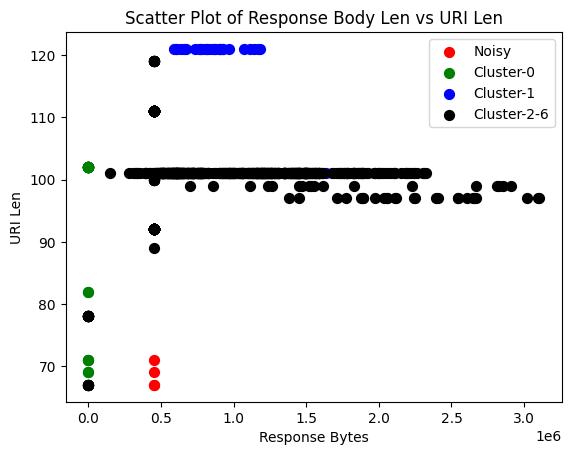

In [53]:
plt.title('Scatter Plot of Response Body Len vs URI Len')
plt.scatter(x=df__1['response_body_len'], y=df__1['uri_len'], c='red', label='Noisy', s=50)
plt.scatter(x=df_0['response_body_len'], y=df_0['uri_len'], c='green', label='Cluster-0', s=50)
plt.scatter(x=df_1['response_body_len'], y=df_1['uri_len'], c='blue', label='Cluster-1', s=50)
plt.scatter(x=df_others['response_body_len'], y=df_others['uri_len'], c='black', label='Cluster-2-6', s=50)
plt.xlabel(xlabel='Response Bytes')
plt.ylabel('URI Len')
plt.legend()

In [54]:
# Ok that's it for this series
# Hope you enjoyed it!

References : Additional Good Reads <br>
https://www.cse.cuhk.edu.hk/~taoyf/paper/sigmod15-dbscan.pdf <br>
https://cran.microsoft.com/snapshot/2021-03-15/web/packages/dbscan/vignettes/dbscan.pdf <br>
https://uwaterloo.ca/data-systems-group/sites/ca.data-systems-group/files/uploads/files/kriegel2017.pdf <br>
http://adc-conferences.org.au/adc2017/documents/JunhaoCan-adc_talk.pdf <br>